In [169]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [170]:
audi = pd.read_csv('audi.csv')
audi['brand'] = 'Audi'

bmw = pd.read_csv('bmw.csv')
bmw['brand'] = 'BMW'

ford = pd.read_csv('ford.csv')
focus = pd.read_csv('focus.csv')
ford['brand'] = 'Ford'
focus['brand'] = 'Ford'

hyundai = pd.read_csv('hyundai.csv')
hyundai['brand'] = 'Hyundai'

merc = pd.read_csv('merc.csv')
cclass = pd.read_csv('cclass.csv')
merc['brand'] = 'Mercedes-Benz'
cclass['brand'] = 'Mercedes-Benz'

skoda = pd.read_csv('skoda.csv')
skoda['brand'] = 'Skoda'

toyota = pd.read_csv('toyota.csv')
toyota['brand'] = 'Toyota'

vauxhall = pd.read_csv('vauxhall.csv')
vauxhall['brand'] = 'Opel'

vw = pd.read_csv('vw.csv')
vw['brand'] = 'Volkswagen'

In [171]:
raw_data = pd.concat([audi, bmw, ford, focus, hyundai, merc, cclass, skoda, toyota, vauxhall, vw], sort=True).reset_index(drop=True)

# Preprocessing

## Exploring the descriptive statistics of the variables

In [172]:
raw_data.describe(include = 'all')

,brand,engineSize,fuelType,mileage,model,mpg,price,tax,tax(£),transmission,year
count,108540,108540.00,108540,108540.00,108540,99187.00,108540.00,94327.00,4860.00,108540,108540.00
unique,9,nan,5,nan,195,nan,nan,nan,nan,4,nan
top,Ford,nan,Petrol,nan,Focus,nan,nan,nan,nan,Manual,nan
freq,23419,nan,59875,nan,10042,nan,nan,nan,nan,61308,nan
mean,NaN,1.66,NaN,23025.93,NaN,55.17,16890.12,120.26,121.15,NaN,2017.10
std,NaN,0.56,NaN,21176.42,NaN,16.14,9756.27,63.40,58.00,NaN,2.13
min,NaN,0.00,NaN,1.00,NaN,0.30,450.00,0.00,0.00,NaN,1970.00
25%,NaN,1.20,NaN,7491.75,NaN,47.10,10229.50,125.00,125.00,NaN,2016.00
50%,NaN,1.60,NaN,17265.00,NaN,54.30,14698.00,145.00,145.00,NaN,2017.00
75%,NaN,2.00,NaN,32236.00,NaN,62.80,20940.00,145.00,145.00,NaN,2019.00


In [173]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 11 columns):
brand           108540 non-null object
engineSize      108540 non-null float64
fuelType        108540 non-null object
mileage         108540 non-null int64
model           108540 non-null object
mpg             99187 non-null float64
price           108540 non-null int64
tax             94327 non-null float64
tax(£)          4860 non-null float64
transmission    108540 non-null object
year            108540 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 9.1+ MB


In [174]:
raw_data.sample(5)

,brand,engineSize,fuelType,mileage,model,mpg,price,tax,tax(£),transmission,year
1357,Audi,2.00,Diesel,43565,A6,58.90,18998,125.00,nan,Semi-Auto,2016
85949,Opel,1.60,Diesel,44036,Astra,72.40,9300,20.00,nan,Manual,2016
50907,Mercedes-Benz,2.10,Diesel,5026,GLA Class,67.30,22599,145.00,nan,Semi-Auto,2019
6908,Audi,1.40,Petrol,40075,A4,51.40,13990,150.00,nan,Manual,2017
74196,Toyota,1.30,Petrol,28854,Yaris,55.00,9995,30.00,nan,Automatic,2016


In [175]:
for col in raw_data.columns.tolist():          
        print('{} column missing values: {}'.format(col, raw_data[col].isnull().sum()))
print('\n')

brand column missing values: 0
engineSize column missing values: 0
fuelType column missing values: 0
mileage column missing values: 0
model column missing values: 0
mpg column missing values: 9353
price column missing values: 0
tax column missing values: 14213
tax(£) column missing values: 103680
transmission column missing values: 0
year column missing values: 0




### Determining the variables of interest / Missing values

#### Taxes

In [176]:
# Due to some research about car taxes in UK I found out that that car 
# can be taxed anything up to £1,000 or more a year, depending on how environmentally-friendly it is
# It means that tax is correlated with fuel-consumption / engine size and sometimes tax is already paid by previous owner
# There are also a lot of missing values in those columns (more than 10% of all values)
# I will simply delete these features
raw_data = raw_data.drop(['tax', 'tax(£)'], axis = 1)

#### Engine Size

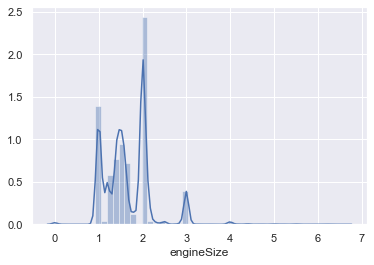

In [177]:
sns.distplot(raw_data['engineSize'])

In [178]:
# Following this graph, we realize we can actually treat EngineV as a categorical variable
raw_data['engV'] = pd.cut(raw_data.engineSize, bins = [0, 1.8, 3, 6.7], labels = ['Small engines', 'Medium engines', 'Large engines'], include_lowest = True)

# There is no cars with petrol or diesel engines smaller than 0.5 dm3. So we can delete these records
raw_data = raw_data.drop(raw_data[(raw_data['engineSize'] <= 0.5) & ((raw_data['fuelType'] == 'Petrol') | (raw_data['fuelType'] == 'Diesel'))].index)
raw_data = raw_data.drop(['engineSize'],axis=1)

In [179]:
# We are checking number of specific groups in fuel type
fuel_types = ['Hybrid', 'Electric', 'Other']
len_fuel = [len(raw_data[(raw_data['fuelType'] == 'Hybrid')]), len(raw_data[(raw_data['fuelType'] == 'Electric')]), len(raw_data[(raw_data['fuelType'] == 'Other')])]
for n in range(3):
    print('Number of {} cars: {}'.format(fuel_types[n], len_fuel[n]))

Number of Hybrid cars: 3229
Number of Electric cars: 6
Number of Other cars: 253


In [180]:
# We can simply drop car's with electric and other types of fuel
raw_data = raw_data.drop(raw_data[((raw_data['fuelType'] == 'Electric') | (raw_data['fuelType'] == 'Other'))].index)

#### Fuel consumption / MPG

In [181]:
### In the first place I will convert mph measure to l/100 which I'm more comfortable with

gallon = 4.54609188
mile = 1.609344
def convert_mpg(mpg):
    return ((100/(mpg*mile))*gallon)

raw_data['mpg'] = convert_mpg(raw_data['mpg'])
raw_data.rename(columns={"mpg": "fuelConsumption"}, inplace=True)
raw_data.describe(include = 'all')

,brand,fuelType,mileage,model,fuelConsumption,price,transmission,year,engV
count,108036,108036,108036.00,108036,98702.00,108036.00,108036,108036.00,108036
unique,9,3,nan,194,nan,nan,4,nan,3
top,Ford,Petrol,nan,Focus,nan,nan,Manual,nan,Small engines
freq,23354,59703,nan,10019,nan,nan,61106,nan,65316
mean,NaN,NaN,23036.75,NaN,5.46,16889.41,NaN,2017.10,NaN
std,NaN,NaN,21188.07,NaN,4.10,9759.52,NaN,2.13,NaN
min,NaN,NaN,1.00,NaN,0.60,450.00,NaN,1970.00,NaN
25%,NaN,NaN,7499.00,NaN,4.50,10231.00,NaN,2016.00,NaN
50%,NaN,NaN,17267.00,NaN,5.20,14695.00,NaN,2017.00,NaN
75%,NaN,NaN,32251.00,NaN,6.00,20932.25,NaN,2019.00,NaN


In [182]:
raw_data['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid'], dtype=object)

In [183]:
# Using median values of the whole data set is not a good choice right now.

In [184]:
fuel_consumption_by_engV_fuelType = raw_data.groupby(['engV', 'fuelType']).median()['fuelConsumption']

for engV in raw_data['engV'].unique():
    for fuelType in raw_data['fuelType'].unique():
        print('Median fuel consumption by {}, {} : {}'.format(engV, fuelType, fuel_consumption_by_engV_fuelType[engV][fuelType]))

Median fuel consumption by Small engines, Petrol : 5.299832141643645
Median fuel consumption by Small engines, Diesel : 4.1973410572006875
Median fuel consumption by Small engines, Hybrid : 3.6215519634564903
Median fuel consumption by Medium engines, Petrol : 7.0975138982313135
Median fuel consumption by Medium engines, Diesel : 4.999664657515155
Median fuel consumption by Medium engines, Hybrid : 3.901672004828815
Median fuel consumption by Large engines, Petrol : 10.088609041057367
Median fuel consumption by Large engines, Diesel : 7.2061493150409754
Median fuel consumption by Large engines, Hybrid : 6.48383482001918


In [185]:
# Filling the missing values in fuel consumption with the medians of engine size and fuel type groups
raw_data['fuelConsumption'] = raw_data.groupby(['engV', 'fuelType'])['fuelConsumption'].apply(lambda x: x.fillna(x.median()))

data = raw_data.reset_index(drop=True)
data.sample(5)

,brand,fuelType,mileage,model,fuelConsumption,price,transmission,year,engV
58174,Mercedes-Benz,Petrol,11000,CL Class,6.91,33799,Semi-Auto,2017,Medium engines
55570,Mercedes-Benz,Petrol,24,C Class,6.69,32995,Semi-Auto,2019,Medium engines
63288,Mercedes-Benz,Diesel,29607,C Class,4.20,17902,Semi-Auto,2016,Small engines
95502,Volkswagen,Petrol,35350,Golf,5.30,11995,Manual,2016,Small engines
87783,Opel,Petrol,11420,Mokka X,6.49,14000,Semi-Auto,2017,Small engines


### Exploring the PDFs and dealing with outliers

In [186]:
# Next step in our data exploration is displaying the probability distribution function (PDF) of a variable

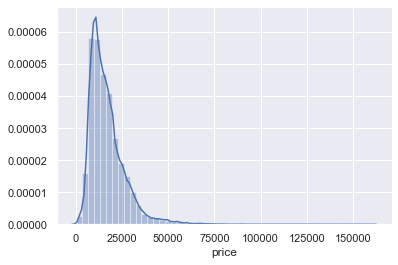

In [187]:
sns.distplot(data['price'])

In [188]:
# There are some outliers present 

# We can deal with the outliers easily by removing 0.5%, or 1% of the problematic samples
# Here, the outliers are situated around the higher prices (right side of the graph)
# This is a dataset about used cars, therefore one can imagine how £150,000 is an excessive price

# Let's declare a variable that will be equal to the 99,5th percentile of the 'Price' variable
q = data['price'].quantile(0.995)
data_1 = data[data['price']<q]

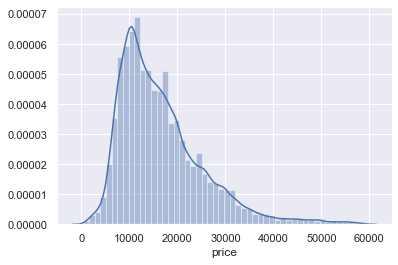

In [189]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers
sns.distplot(data_1['price'])

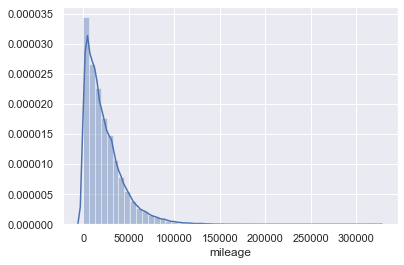

In [190]:
# We'll treat the other numerical variables in a similar way
sns.distplot(data['mileage'])

In [191]:
q = data_1['mileage'].quantile(0.995)
data_2 = data_1[data_1['mileage']<q]

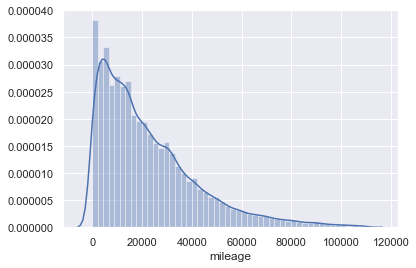

In [192]:
sns.distplot(data_2['mileage'])

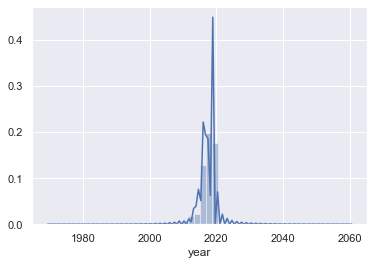

In [193]:
sns.distplot(data['year'])

In [194]:
# The situation with 'year' is similar to 'Price' and 'Mileage'
# However, the outliers are on the low end
# Also the maximum year of a car should be 2020

In [195]:
q = data_2['year'].quantile(0.001)
data_3 = data_2[data_2['year']>q]
data_3 = data_3[data_3['year']<=2020]

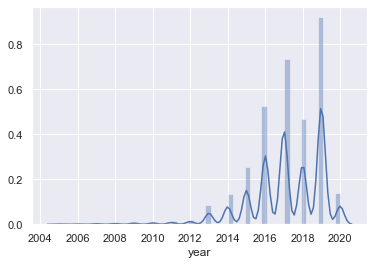

In [196]:
sns.distplot(data_3['year'])

In [197]:
data_3.describe(include='all')

,brand,fuelType,mileage,model,fuelConsumption,price,transmission,year,engV
count,106812,106812,106812.00,106812,106812.00,106812.00,106812,106812.00,106812
unique,9,3,nan,188,nan,nan,4,nan,3
top,Ford,Petrol,nan,Focus,nan,nan,Manual,nan,Small engines
freq,23236,59135,nan,9974,nan,nan,60661,nan,65071
mean,NaN,NaN,22528.01,NaN,5.42,16677.38,NaN,2017.14,NaN
std,NaN,NaN,19692.02,NaN,3.93,8803.85,NaN,1.98,NaN
min,NaN,NaN,1.00,NaN,0.60,675.00,NaN,2005.00,NaN
25%,NaN,NaN,7524.00,NaN,4.50,10291.00,NaN,2016.00,NaN
50%,NaN,NaN,17224.00,NaN,5.20,14698.00,NaN,2017.00,NaN
75%,NaN,NaN,32000.00,NaN,6.00,20799.00,NaN,2019.00,NaN


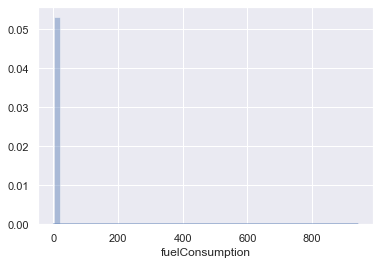

In [198]:
sns.distplot(data['fuelConsumption'])

In [199]:
q = data_3['fuelConsumption'].quantile(0.999)
data_4 = data_3[data_3['fuelConsumption']<q]

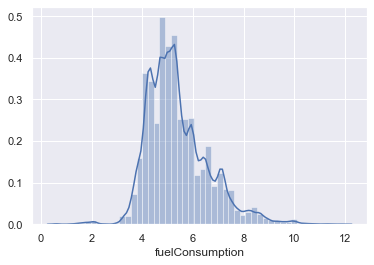

In [200]:
sns.distplot(data_4['fuelConsumption'])

In [201]:
data_cleaned = data_4.reset_index(drop=True)

data_cleaned.describe(include='all')

,brand,fuelType,mileage,model,fuelConsumption,price,transmission,year,engV
count,106702,106702,106702.00,106702,106702.00,106702.00,106702,106702.00,106702
unique,9,3,nan,187,nan,nan,4,nan,3
top,Ford,Petrol,nan,Focus,nan,nan,Manual,nan,Small engines
freq,23195,59057,nan,9974,nan,nan,60637,nan,65061
mean,NaN,NaN,22529.79,NaN,5.38,16661.38,NaN,2017.14,NaN
std,NaN,NaN,19686.43,NaN,1.21,8786.09,NaN,1.98,NaN
min,NaN,NaN,1.00,NaN,0.60,675.00,NaN,2005.00,NaN
25%,NaN,NaN,7532.00,NaN,4.50,10290.00,NaN,2016.00,NaN
50%,NaN,NaN,17228.00,NaN,5.20,14695.00,NaN,2017.00,NaN
75%,NaN,NaN,32000.00,NaN,6.00,20774.00,NaN,2019.00,NaN


## Checking the OLS assumptions

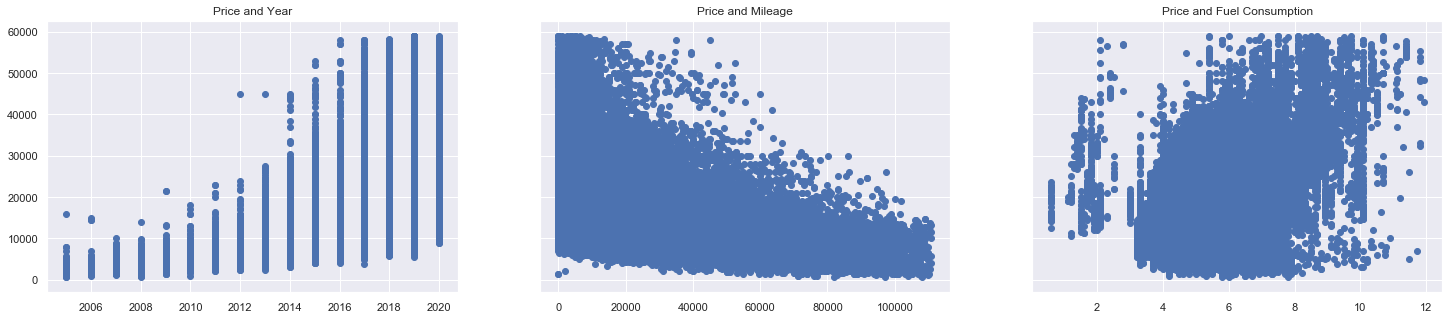

In [202]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(25,5))
ax1.scatter(data_cleaned['year'],data_cleaned['price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['mileage'],data_cleaned['price'])
ax2.set_title('Price and Mileage')
ax3.scatter(data_cleaned['fuelConsumption'],data_cleaned['price'])
ax3.set_title('Price and Fuel Consumption')


plt.show()

In [203]:
df_all_corr2 = raw_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr2.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr2[df_all_corr2['Feature 1'] == 'price']

,Feature 1,Feature 2,Correlation Coefficient
1,price,price,1.00
7,price,year,0.50
8,price,mileage,0.43
10,price,fuelConsumption,0.18


#### Fuel consumption

In [204]:
# As we can see on scatter plots and correlation coefficient table above, fuel consumption and price are not much correlated.
# Fuel consumption is less important selling point that model or a mileage
# I will remove these column

data_cleaned = data_cleaned.drop(['fuelConsumption'],axis=1)

### Relaxing the assumptions

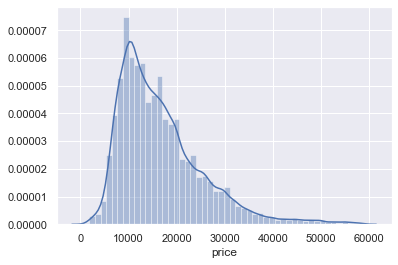

In [205]:
sns.distplot(data_cleaned['price'])

In [206]:
# From the subplots and the PDF of price, we can  determine that 'Price' is exponentially distributed
# Let's transform 'Price' with a log transformation

log_price = np.log(data_cleaned['price'])

# Then we add it to our data frame
data_cleaned['log_price'] = log_price
data_cleaned

,brand,fuelType,mileage,model,price,transmission,year,engV,log_price
0,Audi,Petrol,15735,A1,12500,Manual,2017,Small engines,9.43
1,Audi,Diesel,36203,A6,16500,Automatic,2016,Medium engines,9.71
2,Audi,Petrol,29946,A1,11000,Manual,2016,Small engines,9.31
3,Audi,Diesel,25952,A4,16800,Automatic,2017,Medium engines,9.73
4,Audi,Petrol,1998,A3,17300,Manual,2019,Small engines,9.76
5,Audi,Petrol,32260,A1,13900,Automatic,2016,Small engines,9.54
6,Audi,Diesel,76788,A6,13250,Automatic,2016,Medium engines,9.49
7,Audi,Diesel,75185,A4,11750,Manual,2016,Medium engines,9.37
8,Audi,Petrol,46112,A3,10200,Manual,2015,Small engines,9.23
9,Audi,Petrol,22451,A1,12000,Manual,2016,Small engines,9.39


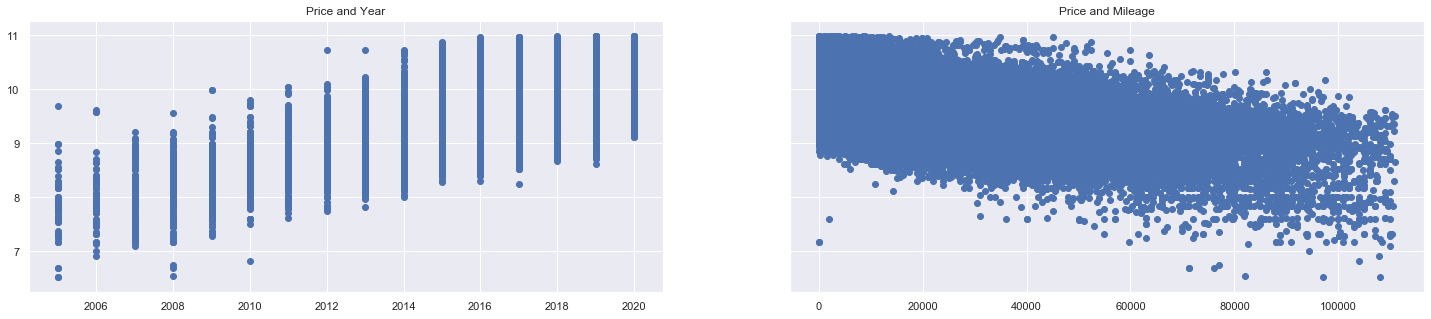

In [207]:
# Let's check the two scatters once again (we deleted the fuel consumption column)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(25,5))
ax1.scatter(data_cleaned['year'],data_cleaned['log_price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['mileage'],data_cleaned['log_price'])
ax2.set_title('Price and Mileage')

plt.show()

In [208]:
# The relationships show a more linear relationship
# This is some good linear regression material

In [209]:
# Since we will be using the log price variable, we can drop the old 'Price' one
data_cleaned = data_cleaned.drop(['price'],axis=1)

### Multicollinearity

In [210]:
# Let's quickly see the columns of our data frame
data_cleaned.columns.values

array(['brand', 'fuelType', 'mileage', 'model', 'transmission', 'year',
       'engV', 'log_price'], dtype=object)

In [211]:
# sklearn does not have a built-in way to check for multicollinearity
# we will try to deal with: 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = data_cleaned[['mileage','year']]

# we create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns

In [212]:
# Let's explore the result
vif

,VIF,Features
0,2.31,mileage
1,2.31,year


In [213]:
# 2.3 is not a big VIF value. We're checking only 2 features but we won't reduce any of them

## Create dummy variables

In [214]:
# To include the categorical data in the regression, let's create dummies
# It is extremely important that we drop one of the dummies, alternatively we will introduce multicollinearity

# I will leave model variable, even it has 187 unique values

data_with_dummies = pd.get_dummies(data_cleaned, drop_first=True)

In [215]:
# Here's the result
data_with_dummies.head()

,mileage,year,log_price,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes-Benz,brand_Opel,brand_Skoda,brand_Toyota,brand_Volkswagen,fuelType_Hybrid,fuelType_Petrol,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,model_ A Class,model_ A1,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Adam,model_ Agila,model_ Amarok,model_ Amica,model_ Ampera,model_ Antara,model_ Arteon,model_ Astra,model_ Auris,model_ Avensis,model_ Aygo,model_ B Class,model_ B-MAX,model_ Beetle,model_ C Class,model_ C-HR,model_ C-MAX,model_ CC,model_ CL Class,model_ CLA Class,model_ CLC Class,model_ CLK,model_ CLS Class,model_ Caddy,model_ Caddy Life,model_ Caddy Maxi,model_ Caddy Maxi Life,model_ California,model_ Camry,model_ Caravelle,model_ Cascada,model_ Citigo,model_ Combo Life,model_ Corolla,model_ Corsa,model_ Crossland X,model_ E Class,model_ EcoSport,model_ Edge,model_ Eos,model_ Fabia,model_ Fiesta,model_ Focus,model_ Fox,model_ Fusion,model_ G Class,model_ GL Class,model_ GLA Class,model_ GLB Class,model_ GLC Class,model_ GLE Class,model_ GLS Class,model_ GT86,model_ GTC,model_ Galaxy,model_ Getz,model_ Golf,model_ Golf SV,model_ Grand C-MAX,model_ Grand Tourneo Connect,model_ Grandland X,model_ Hilux,model_ I10,model_ I20,model_ I30,model_ I40,model_ I800,model_ IQ,model_ IX20,model_ IX35,model_ Insignia,model_ Ioniq,model_ Jetta,model_ KA,model_ Ka+,model_ Kadjar,model_ Kamiq,model_ Karoq,model_ Kodiaq,model_ Kona,model_ Kuga,model_ Land Cruiser,model_ M Class,model_ M2,model_ M3,model_ M4,model_ M5,model_ M6,model_ Meriva,model_ Mokka,model_ Mokka X,model_ Mondeo,model_ Mustang,model_ Octavia,model_ PROACE VERSO,model_ Passat,model_ Polo,model_ Prius,model_ Puma,model_ Q2,model_ Q3,model_ Q5,model_ Q7,model_ Q8,model_ R Class,model_ RAV4,model_ RS3,model_ RS4,model_ RS5,model_ RS6,model_ RS7,model_ Ranger,model_ Rapid,model_ Roomster,model_ S Class,model_ S-MAX,model_ S3,model_ S4,model_ S5,model_ S8,model_ SL CLASS,model_ SLK,model_ SQ5,model_ SQ7,model_ Santa Fe,model_ Scala,model_ Scirocco,model_ Sharan,model_ Shuttle,model_ Streetka,model_ Superb,model_ Supra,model_ T-Cross,model_ T-Roc,model_ TT,model_ Tigra,model_ Tiguan,model_ Tiguan Allspace,model_ Touareg,model_ Touran,model_ Tourneo Connect,model_ Tourneo Custom,model_ Transit Tourneo,model_ Tucson,model_ Up,model_ Urban Cruiser,model_ V Class,model_ Vectra,model_ Veloster,model_ Verso,model_ Verso-S,model_ Viva,model_ Vivaro,model_ X-CLASS,model_ X1,model_ X2,model_ X3,model_ X4,model_ X5,model_ X6,model_ Yaris,model_ Yeti,model_ Yeti Outdoor,model_ Z4,model_ Zafira,model_ Zafira Tourer,model_ i3,model_ i8,model_180,model_200,model_220,transmission_Manual,transmission_Other,transmission_Semi-Auto,engV_Medium engines,engV_Large engines
0,15735,2017,9.43,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,36203,2016,9.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,29946,2016,9.31,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Rearrange a bit

In [216]:
# To make our data frame more organized, we prefer to place the dependent variable in the beginning of the df
# Since each problem is different, that must be done manually
# We can display all possible features and then choose the desired order
data_with_dummies.columns.values

array(['mileage', 'year', 'log_price', 'brand_BMW', 'brand_Ford',
       'brand_Hyundai', 'brand_Mercedes-Benz', 'brand_Opel',
       'brand_Skoda', 'brand_Toyota', 'brand_Volkswagen',
       'fuelType_Hybrid', 'fuelType_Petrol', 'model_ 2 Series',
       'model_ 3 Series', 'model_ 4 Series', 'model_ 5 Series',
       'model_ 6 Series', 'model_ 7 Series', 'model_ 8 Series',
       'model_ A Class', 'model_ A1', 'model_ A3', 'model_ A4',
       'model_ A5', 'model_ A6', 'model_ A7', 'model_ A8', 'model_ Adam',
       'model_ Agila', 'model_ Amarok', 'model_ Amica', 'model_ Ampera',
       'model_ Antara', 'model_ Arteon', 'model_ Astra', 'model_ Auris',
       'model_ Avensis', 'model_ Aygo', 'model_ B Class', 'model_ B-MAX',
       'model_ Beetle', 'model_ C Class', 'model_ C-HR', 'model_ C-MAX',
       'model_ CC', 'model_ CL Class', 'model_ CLA Class',
       'model_ CLC Class', 'model_ CLK', 'model_ CLS Class',
       'model_ Caddy', 'model_ Caddy Life', 'model_ Caddy Maxi',
       

In [217]:
# To make the code a bit more parametrized, let's declare a new variable that will contain the preferred order

# Conventionally, the most intuitive order is: dependent variable, indepedendent numerical variables, dummies
cols = ['log_price', 'mileage', 'year', 'brand_BMW', 'brand_Ford',
       'brand_Hyundai', 'brand_Mercedes-Benz', 'brand_Opel',
       'brand_Skoda', 'brand_Toyota', 'brand_Volkswagen',
       'fuelType_Hybrid', 'fuelType_Petrol', 'model_ 2 Series',
       'model_ 3 Series', 'model_ 4 Series', 'model_ 5 Series',
       'model_ 6 Series', 'model_ 7 Series', 'model_ 8 Series',
       'model_ A Class', 'model_ A1', 'model_ A3', 'model_ A4',
       'model_ A5', 'model_ A6', 'model_ A7', 'model_ A8', 'model_ Adam',
       'model_ Agila', 'model_ Amarok', 'model_ Amica', 'model_ Ampera',
       'model_ Antara', 'model_ Arteon', 'model_ Astra', 'model_ Auris',
       'model_ Avensis', 'model_ Aygo', 'model_ B Class', 'model_ B-MAX',
       'model_ Beetle', 'model_ C Class', 'model_ C-HR', 'model_ C-MAX',
       'model_ CC', 'model_ CL Class', 'model_ CLA Class',
       'model_ CLC Class', 'model_ CLK', 'model_ CLS Class',
       'model_ Caddy', 'model_ Caddy Life', 'model_ Caddy Maxi',
       'model_ Caddy Maxi Life', 'model_ California', 'model_ Camry',
       'model_ Caravelle', 'model_ Cascada', 'model_ Citigo',
       'model_ Combo Life', 'model_ Corolla', 'model_ Corsa',
       'model_ Crossland X', 'model_ E Class', 'model_ EcoSport',
       'model_ Edge', 'model_ Eos', 'model_ Fabia', 'model_ Fiesta',
       'model_ Focus', 'model_ Fox', 'model_ Fusion', 'model_ G Class',
       'model_ GL Class', 'model_ GLA Class', 'model_ GLB Class',
       'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class',
       'model_ GT86', 'model_ GTC', 'model_ Galaxy', 'model_ Getz',
       'model_ Golf', 'model_ Golf SV', 'model_ Grand C-MAX',
       'model_ Grand Tourneo Connect', 'model_ Grandland X',
       'model_ Hilux', 'model_ I10', 'model_ I20', 'model_ I30',
       'model_ I40', 'model_ I800', 'model_ IQ', 'model_ IX20',
       'model_ IX35', 'model_ Insignia', 'model_ Ioniq', 'model_ Jetta',
       'model_ KA', 'model_ Ka+', 'model_ Kadjar', 'model_ Kamiq',
       'model_ Karoq', 'model_ Kodiaq', 'model_ Kona', 'model_ Kuga',
       'model_ Land Cruiser', 'model_ M Class', 'model_ M2', 'model_ M3',
       'model_ M4', 'model_ M5', 'model_ M6', 'model_ Meriva',
       'model_ Mokka', 'model_ Mokka X', 'model_ Mondeo',
       'model_ Mustang', 'model_ Octavia', 'model_ PROACE VERSO',
       'model_ Passat', 'model_ Polo', 'model_ Prius', 'model_ Puma',
       'model_ Q2', 'model_ Q3', 'model_ Q5', 'model_ Q7', 'model_ Q8',
       'model_ R Class', 'model_ RAV4', 'model_ RS3', 'model_ RS4',
       'model_ RS5', 'model_ RS6', 'model_ RS7', 'model_ Ranger',
       'model_ Rapid', 'model_ Roomster', 'model_ S Class',
       'model_ S-MAX', 'model_ S3', 'model_ S4', 'model_ S5', 'model_ S8',
       'model_ SL CLASS', 'model_ SLK', 'model_ SQ5', 'model_ SQ7',
       'model_ Santa Fe', 'model_ Scala', 'model_ Scirocco',
       'model_ Sharan', 'model_ Shuttle', 'model_ Streetka',
       'model_ Superb', 'model_ Supra', 'model_ T-Cross', 'model_ T-Roc',
       'model_ TT', 'model_ Tigra', 'model_ Tiguan',
       'model_ Tiguan Allspace', 'model_ Touareg', 'model_ Touran',
       'model_ Tourneo Connect', 'model_ Tourneo Custom',
       'model_ Transit Tourneo', 'model_ Tucson', 'model_ Up',
       'model_ Urban Cruiser', 'model_ V Class', 'model_ Vectra',
       'model_ Veloster', 'model_ Verso', 'model_ Verso-S', 'model_ Viva',
       'model_ Vivaro', 'model_ X-CLASS', 'model_ X1', 'model_ X2',
       'model_ X3', 'model_ X4', 'model_ X5', 'model_ X6', 'model_ Yaris',
       'model_ Yeti', 'model_ Yeti Outdoor', 'model_ Z4', 'model_ Zafira',
       'model_ Zafira Tourer', 'model_ i3', 'model_ i8', 'model_180',
       'model_200', 'model_220', 'transmission_Manual',
       'transmission_Other', 'transmission_Semi-Auto',
       'engV_Medium engines', 'engV_Large engines']

In [218]:
# To implement the reordering, we will create a new df, which is equal to the old one but with the new order of features
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,mileage,year,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes-Benz,brand_Opel,brand_Skoda,brand_Toyota,brand_Volkswagen,fuelType_Hybrid,fuelType_Petrol,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,model_ A Class,model_ A1,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Adam,model_ Agila,model_ Amarok,model_ Amica,model_ Ampera,model_ Antara,model_ Arteon,model_ Astra,model_ Auris,model_ Avensis,model_ Aygo,model_ B Class,model_ B-MAX,model_ Beetle,model_ C Class,model_ C-HR,model_ C-MAX,model_ CC,model_ CL Class,model_ CLA Class,model_ CLC Class,model_ CLK,model_ CLS Class,model_ Caddy,model_ Caddy Life,model_ Caddy Maxi,model_ Caddy Maxi Life,model_ California,model_ Camry,model_ Caravelle,model_ Cascada,model_ Citigo,model_ Combo Life,model_ Corolla,model_ Corsa,model_ Crossland X,model_ E Class,model_ EcoSport,model_ Edge,model_ Eos,model_ Fabia,model_ Fiesta,model_ Focus,model_ Fox,model_ Fusion,model_ G Class,model_ GL Class,model_ GLA Class,model_ GLB Class,model_ GLC Class,model_ GLE Class,model_ GLS Class,model_ GT86,model_ GTC,model_ Galaxy,model_ Getz,model_ Golf,model_ Golf SV,model_ Grand C-MAX,model_ Grand Tourneo Connect,model_ Grandland X,model_ Hilux,model_ I10,model_ I20,model_ I30,model_ I40,model_ I800,model_ IQ,model_ IX20,model_ IX35,model_ Insignia,model_ Ioniq,model_ Jetta,model_ KA,model_ Ka+,model_ Kadjar,model_ Kamiq,model_ Karoq,model_ Kodiaq,model_ Kona,model_ Kuga,model_ Land Cruiser,model_ M Class,model_ M2,model_ M3,model_ M4,model_ M5,model_ M6,model_ Meriva,model_ Mokka,model_ Mokka X,model_ Mondeo,model_ Mustang,model_ Octavia,model_ PROACE VERSO,model_ Passat,model_ Polo,model_ Prius,model_ Puma,model_ Q2,model_ Q3,model_ Q5,model_ Q7,model_ Q8,model_ R Class,model_ RAV4,model_ RS3,model_ RS4,model_ RS5,model_ RS6,model_ RS7,model_ Ranger,model_ Rapid,model_ Roomster,model_ S Class,model_ S-MAX,model_ S3,model_ S4,model_ S5,model_ S8,model_ SL CLASS,model_ SLK,model_ SQ5,model_ SQ7,model_ Santa Fe,model_ Scala,model_ Scirocco,model_ Sharan,model_ Shuttle,model_ Streetka,model_ Superb,model_ Supra,model_ T-Cross,model_ T-Roc,model_ TT,model_ Tigra,model_ Tiguan,model_ Tiguan Allspace,model_ Touareg,model_ Touran,model_ Tourneo Connect,model_ Tourneo Custom,model_ Transit Tourneo,model_ Tucson,model_ Up,model_ Urban Cruiser,model_ V Class,model_ Vectra,model_ Veloster,model_ Verso,model_ Verso-S,model_ Viva,model_ Vivaro,model_ X-CLASS,model_ X1,model_ X2,model_ X3,model_ X4,model_ X5,model_ X6,model_ Yaris,model_ Yeti,model_ Yeti Outdoor,model_ Z4,model_ Zafira,model_ Zafira Tourer,model_ i3,model_ i8,model_180,model_200,model_220,transmission_Manual,transmission_Other,transmission_Semi-Auto,engV_Medium engines,engV_Large engines
0,9.43,15735,2017,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,9.71,36203,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,9.31,29946,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Linear regression model

### Declare the inputs and the targets

In [219]:
# The target(s) (dependent variable) is 'log price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['log_price'],axis=1)

### Scale the data

In [220]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [221]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [222]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=47)

### Create the regression

In [223]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [224]:
# Let's check the outputs of the regression
# I'll store them in y_hat as this is the 'theoretical' name of the predictions
y_hat = reg.predict(x_train)

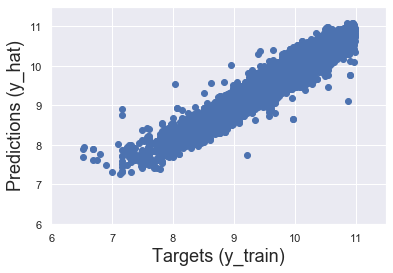

In [225]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)

plt.xlim(6,11.5)
plt.ylim(6,11.5)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

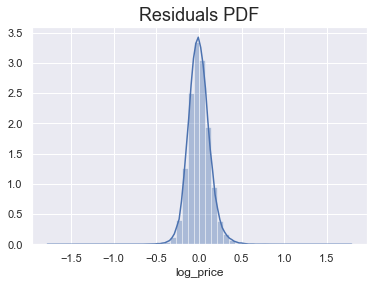

In [226]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed
# In our case we notice that it is true :) 

In [227]:
# Find the R-squared of the model
reg.score(x_train,y_train)

# This is NOT the adjusted R-squared

0.9362000520335929

#### Adjusted R^2

#### Formula:    $R^2_{adj.} = 1 - (1-R^2)*\frac{n-1}{n-p-1}$

In [228]:
x_train.shape

(85361, 203)

In [229]:
def adj_r2(x,y):
    r2 = reg.score(x_train,y_train)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [230]:
# Here's the result
adj_r2(x_train,y_train)

0.936047963662265

In [231]:
# Adjusted R^2 is almost the same as R^2. That means that all variables we added are usefull to a model

### Finding the weights and bias

In [232]:
# Obtain the bias (intercept) of the regression
reg.intercept_

9.593086045512583

In [233]:
# Obtain the weights (coefficients) of the regression
reg.coef_

array([-1.11768115e-01,  2.00322819e-01,  1.82022678e+10,  1.96788417e+10,
        3.46908011e+10, -6.99925452e+10,  4.02021598e+10, -5.47045872e+10,
        1.06488753e+10,  2.30482400e+08,  3.18088531e-02,  2.56090164e-02,
        4.87565994e-04,  1.41839981e-02,  1.18756294e-02,  1.64251328e-02,
        1.12144947e-02,  1.68964863e-02,  7.74723291e-03,  3.85561609e+10,
        6.83270019e+09,  8.08698670e+09,  6.87020599e+09,  5.52334020e+09,
        5.05872336e+09,  2.06974717e+09,  2.01826692e+09, -3.91496125e+09,
       -8.16249675e+08,  1.95294258e+09, -3.25237391e+08, -2.58142586e+08,
       -9.30641649e+08,  2.90549640e+09, -9.47483240e+09,  1.37717253e+09,
        5.36521273e+08,  2.24059661e+09,  1.88805082e+10,  7.79389912e+08,
        1.62683161e+09,  6.50084674e+10,  1.12254368e+09,  9.62183888e+08,
        1.80685117e+09,  1.75285734e+10,  7.17732196e+09,  1.34890243e+09,
        7.78796482e+08,  1.19256257e+10,  4.54273508e+08,  5.24544948e+08,
        3.70916243e+08,  

In [234]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary = reg_summary.sort_values(by = 'Weights', ascending=False)

pd.set_option('display.max_rows', None)

reg_summary

,Features,Weights
41,model_ C Class,65008467438.99
6,brand_Opel,40202159804.19
19,model_ A Class,38556160915.25
67,model_ Fabia,35369025866.35
4,brand_Hyundai,34690801057.81
120,model_ Octavia,34221334248.76
63,model_ E Class,33808245837.50
157,model_ Superb,25134198758.42
76,model_ GLC Class,23684256572.31
74,model_ GLA Class,22535790761.81


## Testing

In [235]:
# Once we have trained and fine-tuned our model, we can proceed to testing it

# Our test inputs are 'x_test', while the outputs: 'y_test' 
# We SHOULD NOT TRAIN THE MODEL ON THEM, we just feed them and find the predictions
# If the predictions are far off, we will know that our model overfitted
y_hat_test = reg.predict(x_test)

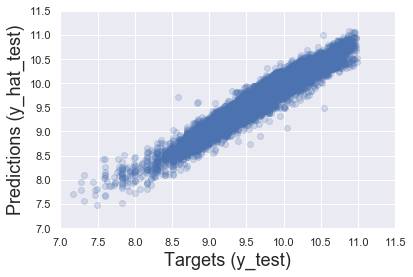

In [236]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(7,11.5)
plt.ylim(7,11.5)
plt.show()

In [237]:
# Finally, let's manually check these predictions
# To obtain the actual prices, we take the exponential of the log_price
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,17514.00
1,18437.25
2,22775.12
3,25122.69
4,25148.87


In [238]:
pd.set_option('display.max_rows', 100)

In [239]:
# To get a proper result, we must reset the index and drop the old indexing
y_test = y_test.reset_index(drop=True)

# Check the result
y_test.head()

0    9.68
1   10.08
2   10.06
3    9.83
4   10.08
Name: log_price, dtype: float64

In [240]:
# We need the exponential of the test log price
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,17514.00,15998.00
1,18437.25,23795.00
2,22775.12,23295.00
3,25122.69,18499.00
4,25148.87,23899.00
5,7739.63,7275.00
6,11207.05,11670.00
7,15390.39,17990.00
8,16177.05,17520.00
9,8924.98,9557.00


In [241]:
# Additionally, we can calculate the difference between the targets and the predictions
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [242]:
# Here, we take the absolute difference in %, so we can easily order the data frame
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,17514.00,15998.00,-1516.00,9.48
1,18437.25,23795.00,5357.75,22.52
2,22775.12,23295.00,519.88,2.23
3,25122.69,18499.00,-6623.69,35.81
4,25148.87,23899.00,-1249.87,5.23
5,7739.63,7275.00,-464.63,6.39
6,11207.05,11670.00,462.95,3.97
7,15390.39,17990.00,2599.61,14.45
8,16177.05,17520.00,1342.95,7.67
9,8924.98,9557.00,632.02,6.61


In [243]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,21341.00,21341.00,21341.00,21341.00
mean,16630.26,16804.61,174.36,9.94
std,8331.13,8895.21,2647.74,8.53
min,1768.51,1295.00,-22144.52,0.00
25%,10498.72,10300.00,-1092.81,3.77
50%,14645.83,14799.00,-44.56,8.00
75%,21241.55,20990.00,1141.06,13.90
max,64616.50,58800.00,24984.15,214.00


In [244]:
# Sometimes it is useful to check these outputs manually
pd.set_option('display.max_rows', 999)
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
20054,11998.95,11999.00,0.05,0.00
11796,11998.95,11999.00,0.05,0.00
20591,15493.83,15494.00,0.17,0.00
15816,9494.81,9495.00,0.19,0.00
14910,9995.21,9995.00,-0.21,0.00
861,24949.26,24950.00,0.74,0.00
654,8499.28,8499.00,-0.28,0.00
1116,11494.59,11495.00,0.41,0.00
19594,10994.59,10995.00,0.41,0.00
1106,6269.70,6270.00,0.30,0.00
